# Latent Direlect Allocation

## Cleaning raw data

In [1]:
import pandas as pd 
import nltk
import json
import re
import string 
import numpy as np
from nltk.corpus import stopwords

from nltk.stem.wordnet import WordNetLemmatizer
from itertools import chain
import os
from pprint import pprint
import matplotlib.pyplot as plt

In [2]:
# Import data.
df = pd.read_csv("data/philosophy_data.csv")
stop_words = set(stopwords.words('english'))

df['sentence_cleaned'] = df['sentence_lowered'].apply(lambda x: ' '.join([word.lower() for word in x.split() if word not in stop_words]))
p1 = df[df['original_publication_date']<0]['sentence_cleaned']
p2 = df[df['original_publication_date']>1600][df['original_publication_date']<1800]['sentence_cleaned']
p3 = df[df['original_publication_date']>1800][df['original_publication_date']<1985]['sentence_cleaned']
X_test = [p1,p2,p3]
X_test

<ipython-input-2-3ac126943d89>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p2 = df[df['original_publication_date']>1600][df['original_publication_date']<1800]['sentence_cleaned']
<ipython-input-2-3ac126943d89>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p3 = df[df['original_publication_date']>1800][df['original_publication_date']<1985]['sentence_cleaned']


[0        what's new, socrates, make leave usual haunts ...
 1                surely prosecuting anyone king archon am?
 2        athenians call prosecution indictment, euthyphro.
 3                                                     say?
 4        someone must indicted you, going tell indicted...
                                ...                        
 87140    ; great advantage, since concentrated effect p...
 87141    consider oedipus sophocles, instance, effect e...
 87142    less unity imitation epic poets, proved fact o...
 87143    saying less unity epic, mean epic made plurali...
 87144    if, then, tragedy superior respects, also, bes...
 Name: sentence_cleaned, Length: 87145, dtype: object,
 87145     reader, thou hast beginning end discourse conc...
 87146     these, remain, hope sufficient establish thron...
 87147     papers evidence, flatter found them, great mis...
 87148     king, body nation, since thoroughly confuted h...
 87149     think worth examine works thro

#inspired by https://github.com/anthdm/ml-email-clustering/blob/master/helpers.py
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#14computemodelperplexityandcoherencescore
# Preprocessing
- tokenize words and clean-up text
- create bigram and trigram models
- Remove Stopwords, Make Bigrams 



In [3]:
from gensim.models import Phrases  #https://radimrehurek.com/gensim/corpora/dictionary.html
from gensim import corpora
from gensim import models
from gensim.models.coherencemodel import CoherenceModel

from gensim.utils import simple_preprocess

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = []
for p in range(3):
    data_words.append(list(sent_to_words(X_test[p])))

print(data_words[0][:1])

[['what', 'new', 'socrates', 'make', 'leave', 'usual', 'haunts', 'lyceum', 'spend', 'time', 'king', 'archon', 'court']]


In [9]:
# Build the bigram and trigram models
#bigram = models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
#trigram = models.Phrases(bigram[data_words], threshold=100) 

bigram_mod = []
trigram_mod = []

for p in range(3):
    bigram = models.Phrases(data_words[p], min_count=3) # higher threshold fewer phrases.
    trigram = models.Phrases(bigram[data_words[p]])  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod.append(models.phrases.Phraser(bigram))
    trigram_mod.append(models.phrases.Phraser(trigram))

# See trigram example
print(trigram_mod[0][bigram_mod[0][data_words[0][0]]])

['what', 'new', 'socrates', 'make', 'leave', 'usual', 'haunts', 'lyceum', 'spend_time', 'king_archon', 'court']


In [11]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    #stop_words = set(stopwords.words('english'))
    extra_stopwords = ['would','take','without','even','get','hold','go','much','somewhere', 'might','must','make','therein','come','amp','dont']
    my_stopwords = stopwords.words('english') + extra_stopwords
    stop_words = set(my_stopwords)
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

#def make_bigrams(texts):
#    return [bigram_mod[doc] for doc in texts]

#def make_trigrams(texts):
#    return [trigram_mod[bigram_mod[doc]] for doc in texts]

#def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
#    """https://spacy.io/api/annotation"""
#    texts_out = []
#    for sent in texts:
#        doc = nlp(" ".join(sent)) 
#        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
#    return texts_out

In [12]:
# Remove Stop Words
data_words_nostops = []
for p in range(3):
    data_words_nostops.append(remove_stopwords(data_words[p]))

# Form Bigrams
def make_bigrams0(texts):
    return [bigram_mod[0][doc] for doc in texts]
def make_bigrams1(texts):
    return [bigram_mod[1][doc] for doc in texts]
def make_bigrams2(texts):
    return [bigram_mod[2][doc] for doc in texts]

data_words_bigrams = []
data_words_bigrams.append(make_bigrams0(data_words_nostops[0]))
data_words_bigrams.append(make_bigrams1(data_words_nostops[1]))
data_words_bigrams.append(make_bigrams2(data_words_nostops[2]))

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
#nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
#data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#print(data_lemmatized[:1])
print(data_words_bigrams[0][:2])

[['new', 'socrates', 'leave', 'usual', 'haunts', 'lyceum', 'spend_time', 'king_archon', 'court'], ['surely', 'prosecuting', 'anyone', 'king_archon']]


## LDA -- 1

In [13]:
print(type(data_words_bigrams[0]))

<class 'list'>


In [14]:
corpus = []
for p in range(3):
    # text: tokenized and pre-processed list of tweets.
    texts = data_words_bigrams[p]

    # Create Dictionary
    id2word = corpora.Dictionary(texts)

    # Term Document Frequency
    corpus.append([id2word.doc2bow(text) for text in texts])

# View
print(corpus[0][:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]]


In [15]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[0][:1]]

[[('although', 1),
  ('attempt', 1),
  ('book', 1),
  ('find', 1),
  ('first_sight', 1),
  ('grown', 1),
  ('harmonize', 1),
  ('inconsistent', 1),
  ('one', 1)]]

In [16]:
# Build LDA model
lda_model = models.ldamodel.LdaModel(corpus=corpus[0],
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [17]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus[0]]

[(0,
  '0.116*"simple" + 0.110*"perplexities" + 0.088*"instinct" + '
  '0.087*"occasions" + 0.070*"position" + 0.027*"method" + 0.017*"matter" + '
  '0.016*"friends" + 0.015*"meaning" + 0.000*"traffic"'),
 (1,
  '0.240*"views" + 0.145*"things" + 0.109*"standpoint" + 0.093*"show" + '
  '0.068*"great_deal" + 0.044*"different_ways" + 0.032*"unfamiliar" + '
  '0.019*"used" + 0.017*"preliminary" + 0.015*"subject"'),
 (2,
  '0.466*"formerly" + 0.128*"exists" + 0.080*"eg" + 0.035*"whoever" + '
  '0.018*"convinced" + 0.000*"traffic" + 0.000*"acknowledged" + '
  '0.000*"questioned" + 0.000*"main" + 0.000*"stands"'),
 (3,
  '0.066*"harmonize" + 0.000*"encapsulations" + 0.000*"city" + '
  '0.000*"external_observation" + 0.000*"acknowledged" + 0.000*"questioned" + '
  '0.000*"reinforce" + 0.000*"consciously" + 0.000*"interpretation" + '
  '0.000*"whole_range"'),
 (4,
  '0.120*"necessity" + 0.096*"see_hear" + 0.094*"maintain" + 0.060*"concerned" '
  '+ 0.052*"country" + 0.045*"dream" + 0.043*"origi

In [18]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus[0]))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -25.15051556703803

Coherence Score:  0.568098502247547


## Building LDA Mallet Model

In [32]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
os.environ.update({'MALLET_HOME':r'C:/Users/esong/Code/test/mallet-2.0.8/bin'})
#mallet_path = 'C:/Users/esong/Code/test/mallet-2.0.8/bin/mallet.bat' # update this path
mallet_path = r'C:/Users/esong/Code/test/mallet-2.0.8/bin/mallet.bat' # update this path
ldamallet = models.wrappers.LdaMallet(mallet_path, corpus=corpus[0], num_topics=20, id2word=id2word)

In [33]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=texts, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(14,
  [('whollydominated', 0.06723616027910317),
   ('prospective', 0.034015699553640144),
   ('optic_nerve', 0.02944948950797804),
   ('berkeleian', 0.02665332717664563),
   ('assert', 0.02198450566928326),
   ('proposing', 0.019316607665076188),
   ('hear', 0.01587912369811708),
   ('joy', 0.01572520650556667),
   ('field', 0.015571289313016264),
   ('images_copies', 0.014442563234313272)]),
 (17,
  [('existence', 0.0691207415496897),
   ('two_different', 0.03313533814559305),
   ('happening', 0.027808113363343365),
   ('dr', 0.020882721146418773),
   ('respect', 0.020829448898596278),
   ('xxi', 0.0161681272141278),
   ('resolutely', 0.013744239938204193),
   ('ten', 0.01174653064486056),
   ('growth', 0.01174653064486056),
   ('slips', 0.011373624910103082)]),
 (3,
  [('single_observer', 0.034008154415403835),
   ('relations', 0.024298272489453467),
   ('strong', 0.024251137140298366),
   ('schools', 0.020197497112959865),
   ('observing_consciousness', 0.019655440597676228),
   

## Find the optimal number of topics for LDA

In [34]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

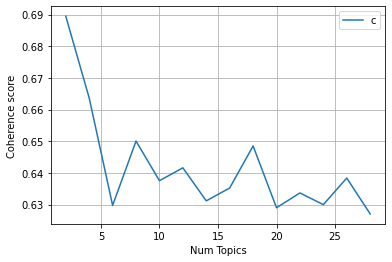

In [35]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus[0], texts=texts, start=2, limit=30, step=2)
# Show graph
limit=30; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.grid()
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [36]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.6895
Num Topics = 4  has Coherence Value of 0.6636
Num Topics = 6  has Coherence Value of 0.6297
Num Topics = 8  has Coherence Value of 0.65
Num Topics = 10  has Coherence Value of 0.6375
Num Topics = 12  has Coherence Value of 0.6416
Num Topics = 14  has Coherence Value of 0.6312
Num Topics = 16  has Coherence Value of 0.6352
Num Topics = 18  has Coherence Value of 0.6485
Num Topics = 20  has Coherence Value of 0.629
Num Topics = 22  has Coherence Value of 0.6337
Num Topics = 24  has Coherence Value of 0.63
Num Topics = 26  has Coherence Value of 0.6384
Num Topics = 28  has Coherence Value of 0.6271


In [50]:
print(type(model_list[0]))

<class 'gensim.models.wrappers.ldamallet.LdaMallet'>


D:\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [51]:
# Select the model and print the topics
optimal_model = model_list[0]
model_topics = optimal_model.show_topics(formatted=False, num_topics = 2)
pprint(optimal_model.print_topics(num_words=15))

[(0,
  '0.014*"traffic" + 0.009*"things" + 0.008*"desire" + 0.008*"exists" + '
  '0.007*"acknowledged" + 0.007*"mere" + 0.007*"whollydominated" + '
  '0.007*"existence" + 0.007*"occur" + 0.007*"surrounding" + 0.006*"permanent" '
  '+ 0.006*"stands" + 0.006*"attracted" + 0.005*"habit" + 0.005*"verhaltniss"'),
 (1,
  '0.018*"information" + 0.012*"essentially" + 0.011*"feeling" + '
  '0.011*"events" + 0.010*"called" + 0.010*"believing" + 0.007*"question" + '
  '0.007*"psychologie" + 0.007*"views" + 0.007*"physicists" + '
  '0.007*"sensations_images" + 0.006*"stuff" + 0.006*"outlook" + 0.006*"easy" '
  '+ 0.005*"every_respect"')]


D:\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
print(len(model_topics))

2


D:\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Visualization

D:\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


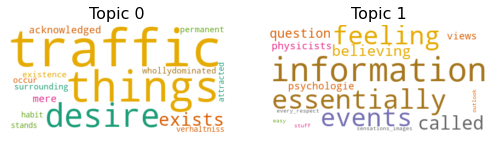

'\nfor i, ax in enumerate(axes.flatten()):\n    ##fig.add_subplot(ax)\n     \n    topic_words = dict(topics[i][1])\n    cloud.generate_from_frequencies(topic_words, max_font_size=300)\n    #plt.gca().imshow(cloud, interpolation="bilinear")\n    plt.imshow(cloud, interpolation="bilinear")\n    plt.gca().set_title(\'Topic \' + str(i), fontdict=dict(size=16))\n    #plt.gca().axis(\'off\')\n\nplt.subplots_adjust(wspace=0, hspace=0)\nplt.axis(\'off\')\nplt.margins(x=0, y=0)\nplt.tight_layout()\nplt.show()\n'

In [53]:
#word cloud based on optimal LDA Mallet model
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

from nltk.corpus import stopwords
 
extra_stopwords = ['would','take','without','even','get','hold','go','much','somewhere', 'might','must','make','therein','come','amp','dont']
#my_stopwords = stopwords.words('english') + extra_stopwords + stopwords.words('longStopWords.txt')
my_stopwords = stopwords.words('english') + extra_stopwords

cols = [color for nam, color in mcolors.TABLEAU_COLORS.items()]
'''
cloud = WordCloud(stopwords=my_stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=15,
                  colormap='Dark2',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)
'''
topics  = optimal_model.show_topics(formatted=False, num_words = 15, num_topics = 8)
#initiate wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

numOfRows = len(topics) // 4
#fig, axes = plt.subplots(numOfRows, 5, figsize=(10,8), sharex=True, sharey=True)
plt.rcParams['figure.figsize'] = [18,18]
# Create subplots for each topic
for i in range(len(model_topics)):

    #wc.generate(text=topics_df["Terms per Topic"][i])
    topic_words = dict(topics[i][1])
    wc.generate_from_frequencies(topic_words, max_font_size=200)
    plt.subplot(6, 4, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title('Topic ' + str(i), fontdict=dict(size=16))

plt.show()
'''
for i, ax in enumerate(axes.flatten()):
    ##fig.add_subplot(ax)
     
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    #plt.gca().imshow(cloud, interpolation="bilinear")
    plt.imshow(cloud, interpolation="bilinear")
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    #plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()
'''

In [54]:
print('amp' in my_stopwords)

True


D:\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
print(topics[1][1])

[('information', 0.0182317478158688), ('essentially', 0.011980789863587596), ('feeling', 0.011191437183875746), ('events', 0.010902774229806365), ('called', 0.009819649517192051), ('believing', 0.009740458795279211), ('question', 0.007152710366320952), ('psychologie', 0.007058192407908854), ('views', 0.007053083329075767), ('physicists', 0.006902365503499719), ('sensations_images', 0.006603484391764165), ('stuff', 0.006115567363204414), ('outlook', 0.0060670311142900935), ('easy', 0.005883104276298983), ('every_respect', 0.005387523629489603)]


D:\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [57]:
#convert LDA mallet to LDA model
def convertldaGenToldaMallet(mallet_model):
    model_gensim = models.ldamodel.LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha, eta=0,
    )
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

optimal_model = convertldaGenToldaMallet(optimal_model)

D:\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [58]:
#conda install -c conda-forge pyldavis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus[0], dictionary=lda_model.id2word)
vis

D:\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.332384  0.0       1        1  50.158369
1     -0.332384  0.0       2        1  49.841631, topic_info=            Term         Freq        Total Category  logprob  loglift
114  information  7705.000000  7705.000000  Default  30.0000  30.0000
415      traffic  5905.000000  5905.000000  Default  29.0000  29.0000
17   essentially  5063.000000  5063.000000  Default  28.0000  28.0000
69       feeling  4730.000000  4730.000000  Default  27.0000  27.0000
49        events  4608.000000  4608.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
102         work  1251.383130  1251.383130   Topic2  -5.8223   0.6963
39     exponents  1188.759937  1188.759937   Topic2  -5.8737   0.6963
399        views  2981.077407  3045.460403   Topic2  -4.9543   0.6750
775         part  1415.498964  1424.228862   Topic2  -5.6991   0.6902
381         easy  2486.570516  2664.442184   Topic2  -5.1357   0.6272

[154 rows x 6 columns], token_table=       Topic      Freq             Term
term                                   
366        2  0.926175         accepted
138        2  0.999747         accurate
567        1  1.000103     acknowledged
370        2  0.926175    alternatively
276        2  0.984061        among_men
...      ...       ...              ...
551        2  0.999744           volume
23758      1  0.998949      wavelengths
1911       1  1.000244            waves
1482       1  0.999890  whollydominated
102        2  0.999694             work

[132 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [ ]:
pyLDAvis.save_html(vis, 'lda_period1.html')